In [1]:
import sys
sys.path.append("./source")

# libraries for this project
from lmmNet import *
import harmonic
import train_onestep
from predict_onestep import *
import predict_lmmNet

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.base import clone
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

# 1. Data Preparation

Here we test our methods on the 2-D Cubic Harmonic Oscillator

$$ \begin{array}
\dot{x_1} & = & -0.1 x_1^3 + 2.0 x_2^3 \\
\dot{x_2} & = & -2.0 x_1^3 - 0.1 x_2^3 \\
\end{array} $$

with the initial conditions $x_1(0) = 2, x_2(0) = 0$. We will use three different approaches:
1. LmmNet
2. One-step machine learning method
3. Recurrent approach

We will also investigate how the method performs under noisy conditions.

In [2]:
time_points, cubic_data = harmonic.simulate_default()

Text(0.5, 1.0, 'Phase Portrait of the 2-D Harmonic Oscillator')

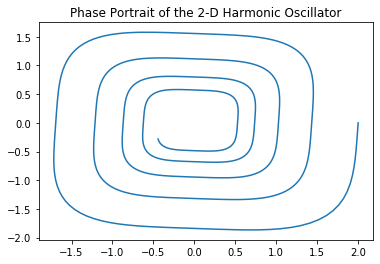

In [3]:
# Phase plane plot
plt.plot(cubic_data[0,:,0], cubic_data[0,:,1])
plt.title('Phase Portrait of the 2-D Harmonic Oscillator')

Now that we have simulated a dataset, let's create a suitable training data and augment it for learning.

In [4]:
# create a pandas dataframe from the tensors

df = pd.DataFrame(cubic_data.numpy()[0])
df.columns = ['x_component', 'y_component']
df['Strain'] = [0] * df.shape[0]
df = df.set_index('Strain')
df['Time'] = time_points
df.head()

,x_component,y_component,Time
Strain,,,
0,2.000000,0.000000,0.00
0,1.992028,-0.159044,0.01
0,1.983873,-0.316164,0.02
0,1.974847,-0.471225,0.03
0,1.963856,-0.623866,0.04


# 2. LmmNet

Next, we train the LmmNet on the tensor data.

In [5]:
# we specify a LMM scheme and number of steps
dt = time_points[1] - time_points[0]
M = 1
scheme = 'AM'
model = lmmNet(dt, cubic_data, M, scheme, hidden_units=256)

N_Iter = 10000
model.train(N_Iter, debug=False)

In [7]:
import predict_lmmNet

x0 = cubic_data[0,0,:] # initial conditions
predicted_traj = odeint(lambda x, t: predict_lmmNet.predict_fn(x, t, model), x0, time_points)

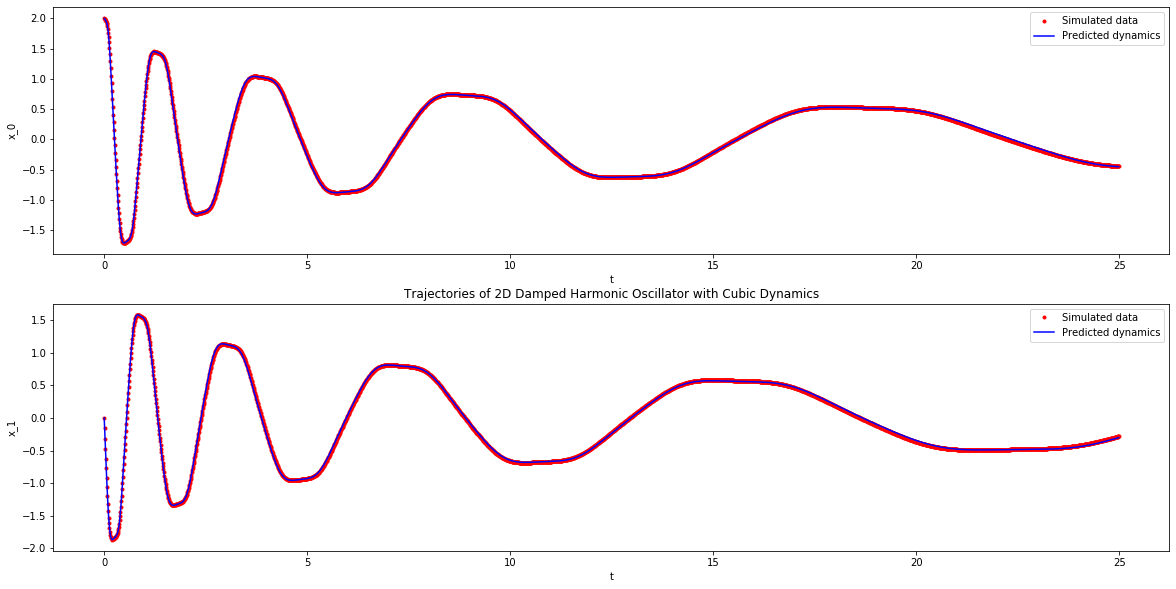

In [10]:
# plot the time-course of the predicted trajectory

plt.figure(figsize=(20, 10))

for species in range(2):
    plt.subplot(2,1,species + 1)
    plt.plot(time_points, cubic_data[0,:, species], 'r.', label='Simulated data')
    plt.plot(time_points, predicted_traj[:,species], 'b-', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('x_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 2D Damped Harmonic Oscillator with Cubic Dynamics')
plt.show()

Text(0.5, 1.0, 'Phase plane of 2D Damped Harmonic Oscillator with Cubic Dynamics')

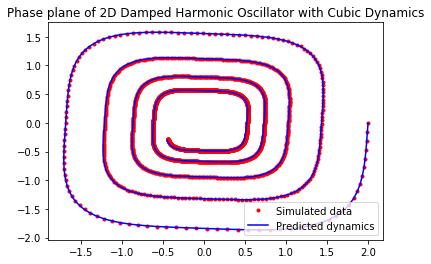

In [11]:
# Phase plane

plt.plot(cubic_data[0,:,0], cubic_data[0,:,1], 'r.', label='Simulated data')
plt.legend()
plt.plot(predicted_traj[:,0], predicted_traj[:,1], 'b-', label='Predicted dynamics')
plt.legend()
plt.title('Phase plane of 2D Damped Harmonic Oscillator with Cubic Dynamics')

# 3. One-step machine learning method

Workflow:
* create and augment training data
* fit model with pairs of derivatives and time-series measurements as features
* make predictions and simulations by numerical integration of the learned model

In [12]:
# now generate and augment the training dataset
print('Original data shape:', df.shape)

feature_list = [] # here we do not have external time-series or control variables
target_list = ['x_component', 'y_component']

df_train = train_onestep.generate_dataset(df, [0],feature_list, target_list, n_dim=7500)
display(df_train)

Original data shape: (2500, 3)


feature      target     feature      target
                 x_component x_component y_component y_component
Strain Time                                                     
0      0.000000     1.999996   -0.793441    0.000046  -15.947814
       0.003332     1.997352   -0.796049   -0.053092  -15.920324
       0.006665     1.994691   -0.801263   -0.106047  -15.865342
       0.009997     1.992012   -0.802554   -0.158819  -15.817866
       0.013330     1.989343   -0.810050   -0.211457  -15.755714
...                      ...         ...         ...         ...
       24.976670   -0.442784   -0.036881   -0.283558    0.175944
       24.980003   -0.442906   -0.036603   -0.282972    0.176070
       24.983335   -0.443028   -0.036388   -0.282385    0.176167
       24.986668   -0.443149   -0.036141   -0.281798    0.176279
       24.990000   -0.443269   -0.036017   -0.281210    0.176334

[7500 rows x 4 columns]

x_component


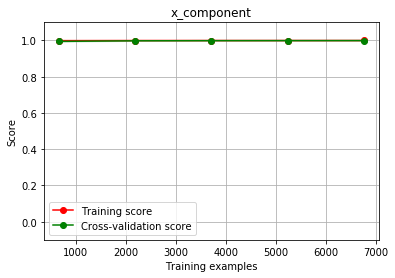

Target: x_component, CV Pearson R2 coefficient: 0.999918
y_component


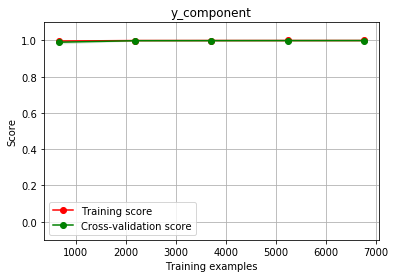

Target: y_component, CV Pearson R2 coefficient: 0.999941
Average training score: 0.9999296206649366


In [13]:
# create a random forest model with 20 estimators
rf_model = RandomForestRegressor(n_estimators=20)
figure_path = './plots/'

# train a model
rf_dict, score_dict = train_onestep.train_classic(df_train, rf_model, plot=True,model_type='random_forest', figure_path=figure_path)

In [14]:
# generate reports on the residual errors

compute_error(df_train,rf_dict,plot=True,model_type='random_forest')

NameError: name 'compute_error' is not defined